In [55]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from os.path import join

In [60]:
def load_and_trim_df(path: str) -> pd.DataFrame:
    split_path = path.split(os.sep)
    trainer_type, intersection = split_path[2:4]
    df = pd.read_csv(path)
    df["trainer_type"] = [trainer_type] * len(df)
    df["intersection"] = [intersection] * len(df)
    return df

In [72]:
sarl_dfs = [
    load_and_trim_df(join("out", "data", "SARL", "two_inter", "unranked_10.csv")),
    load_and_trim_df(join("out", "data", "SARL", "two_inter", "ranked_10.csv")),
    load_and_trim_df(join("out", "data", "SARL", "single_inter", "unranked_9.csv")),
    load_and_trim_df(join("out", "data", "SARL", "single_inter", "ranked_9.csv")),
    load_and_trim_df(join("out", "data", "SARL", "complex_inter", "unranked_10.csv")),
    load_and_trim_df(join("out", "data", "SARL", "complex_inter", "ranked_12.csv")),
    load_and_trim_df(join("out", "data", "SARL", "boston", "unranked_1.csv")),
    load_and_trim_df(join("out", "data", "SARL", "boston", "ranked_1.csv")),
]
marl_dfs = [
    load_and_trim_df(join("out", "data", "MARL", "two_inter", "unranked_10.csv")),
    load_and_trim_df(join("out", "data", "MARL", "two_inter", "ranked_10.csv")),
    load_and_trim_df(join("out", "data", "MARL", "single_inter", "unranked_9.csv")),
    load_and_trim_df(join("out", "data", "MARL", "single_inter", "ranked_10.csv")),
    load_and_trim_df(join("out", "data", "MARL", "complex_inter", "unranked_10.csv")),
    load_and_trim_df(join("out", "data", "MARL", "complex_inter", "ranked_13.csv")),
    load_and_trim_df(join("out", "data", "MARL", "boston", "unranked_1.csv")),
    load_and_trim_df(join("out", "data", "MARL", "boston", "ranked_1.csv")),
]
df = pd.concat(marl_dfs+sarl_dfs)
print(f"Data Columns: {df.columns}\n")
df.head()

Data Columns: Index(['Unnamed: 0', 'round', 'trainer', 'policy', 'episode_reward_max',
       'episode_reward_min', 'episode_reward_mean', 'episode_len_mean',
       'episode_media', 'episodes_this_iter', 'policy_reward_min',
       'policy_reward_max', 'policy_reward_mean', 'custom_metrics',
       'hist_stats', 'sampler_perf', 'off_policy_estimator',
       'num_healthy_workers', 'timesteps_total', 'agent_timesteps_total',
       'timers', 'info', 'done', 'episodes_total', 'training_iteration',
       'experiment_id', 'date', 'timestamp', 'time_this_iter_s',
       'time_total_s', 'pid', 'hostname', 'node_ip', 'config',
       'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'perf', 'callback_ok', 'trainer_type',
       'intersection'],
      dtype='object')



,Unnamed: 0,round,trainer,policy,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episode_media,episodes_this_iter,...,hostname,node_ip,config,time_since_restore,timesteps_since_restore,iterations_since_restore,perf,callback_ok,trainer_type,intersection
0,0,0,MARL,gneJ12,-159.402778,-159.402778,-159.402778,2754.0,{},1,...,DESKTOP-NJNGBTT,172.31.40.24,"{'num_workers': 0, 'num_envs_per_worker': 1, '...",92.997150,0,1,"{'cpu_util_percent': 16.995419847328243, 'ram_...",True,MARL,two_inter
1,1,0,MARL,light1,-159.402778,-159.402778,-159.402778,2754.0,{},1,...,DESKTOP-NJNGBTT,172.31.40.24,"{'num_workers': 0, 'num_envs_per_worker': 1, '...",92.997150,0,1,"{'cpu_util_percent': 16.995419847328243, 'ram_...",True,MARL,two_inter
2,2,0,MARL,TEST-EVAL_POLICY,-159.402778,-159.402778,-159.402778,2754.0,{},1,...,DESKTOP-NJNGBTT,172.31.40.24,"{'num_workers': 0, 'num_envs_per_worker': 1, '...",92.997150,0,1,"{'cpu_util_percent': 16.995419847328243, 'ram_...",True,MARL,two_inter
3,3,1,MARL,gneJ12,-159.402778,-425.326389,-292.364583,2866.5,{},1,...,DESKTOP-NJNGBTT,172.31.40.24,"{'num_workers': 0, 'num_envs_per_worker': 1, '...",198.257493,0,2,"{'cpu_util_percent': 18.70743243243243, 'ram_u...",True,MARL,two_inter
4,4,1,MARL,light1,-159.402778,-425.326389,-292.364583,2866.5,{},1,...,DESKTOP-NJNGBTT,172.31.40.24,"{'num_workers': 0, 'num_envs_per_worker': 1, '...",198.257493,0,2,"{'cpu_util_percent': 18.70743243243243, 'ram_u...",True,MARL,two_inter


In [63]:
df["custom_metrics"]

0       {'edge_to_tls_action_comms___light1_mean': 0.0...
1       {'edge_to_tls_action_comms___light1_mean': 0.0...
2       {'edge_to_tls_action_comms___light1_mean': 0.0...
3       {'edge_to_tls_action_comms___light1_mean': 0.0...
4       {'edge_to_tls_action_comms___light1_mean': 0.0...
                              ...                        
1995    {'edge_to_tls_action_comms___cluster_209579129...
1996    {'edge_to_tls_action_comms___cluster_209579129...
1997    {'edge_to_tls_action_comms___cluster_209579129...
1998    {'edge_to_tls_action_comms___cluster_209579129...
1999    {'edge_to_tls_action_comms___cluster_209579129...
Name: custom_metrics, Length: 6400, dtype: object

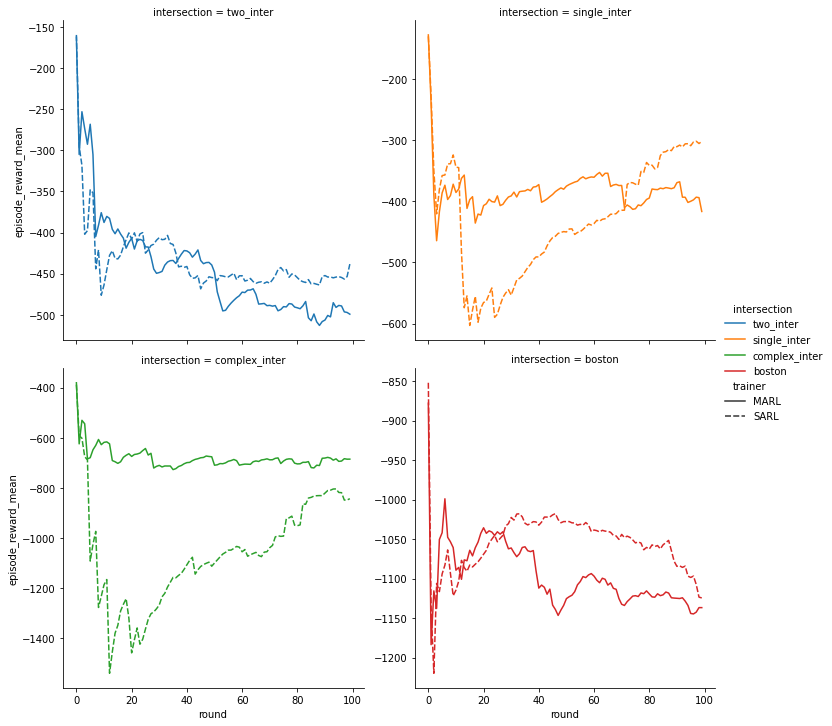

In [75]:
sns.relplot(
    data=df, 
    kind="line", 
    x="round", 
    y="episode_reward_mean", 
    style="trainer", 
    hue="intersection", 
    col="intersection",
    col_wrap=2,
    facet_kws={"sharey": False},
    ci=None
)
plt.show()

In [76]:
comm_df = df.copy()
comm_df.head()

,Unnamed: 0,round,trainer,policy,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episode_media,episodes_this_iter,...,hostname,node_ip,config,time_since_restore,timesteps_since_restore,iterations_since_restore,perf,callback_ok,trainer_type,intersection
0,0,0,MARL,gneJ12,-159.402778,-159.402778,-159.402778,2754.0,{},1,...,DESKTOP-NJNGBTT,172.31.40.24,"{'num_workers': 0, 'num_envs_per_worker': 1, '...",92.997150,0,1,"{'cpu_util_percent': 16.995419847328243, 'ram_...",True,MARL,two_inter
1,1,0,MARL,light1,-159.402778,-159.402778,-159.402778,2754.0,{},1,...,DESKTOP-NJNGBTT,172.31.40.24,"{'num_workers': 0, 'num_envs_per_worker': 1, '...",92.997150,0,1,"{'cpu_util_percent': 16.995419847328243, 'ram_...",True,MARL,two_inter
2,2,0,MARL,TEST-EVAL_POLICY,-159.402778,-159.402778,-159.402778,2754.0,{},1,...,DESKTOP-NJNGBTT,172.31.40.24,"{'num_workers': 0, 'num_envs_per_worker': 1, '...",92.997150,0,1,"{'cpu_util_percent': 16.995419847328243, 'ram_...",True,MARL,two_inter
3,3,1,MARL,gneJ12,-159.402778,-425.326389,-292.364583,2866.5,{},1,...,DESKTOP-NJNGBTT,172.31.40.24,"{'num_workers': 0, 'num_envs_per_worker': 1, '...",198.257493,0,2,"{'cpu_util_percent': 18.70743243243243, 'ram_u...",True,MARL,two_inter
4,4,1,MARL,light1,-159.402778,-425.326389,-292.364583,2866.5,{},1,...,DESKTOP-NJNGBTT,172.31.40.24,"{'num_workers': 0, 'num_envs_per_worker': 1, '...",198.257493,0,2,"{'cpu_util_percent': 18.70743243243243, 'ram_u...",True,MARL,two_inter


In [77]:
import ast

In [78]:
def sum_comm_cost(data):
    data = ast.literal_eval(data)
    return sum(data.values())

comm_df["custom_metrics"] = comm_df.apply(lambda row: sum_comm_cost(row["custom_metrics"]), axis=1)

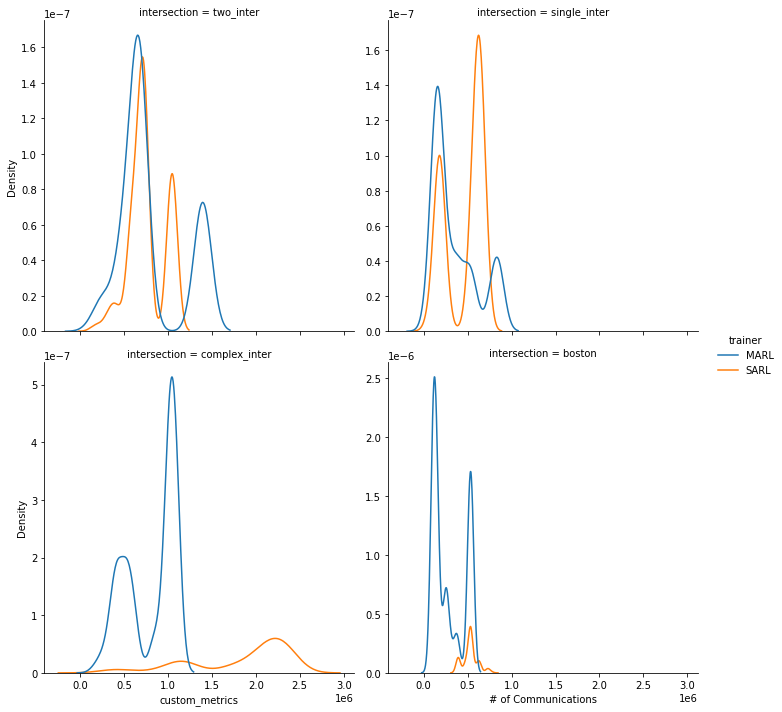

In [86]:
sns.displot(
    data=comm_df, 
    kind="kde", 
    # x="round", 
    x="custom_metrics", 
    # style="trainer", 
    hue="trainer", 
    col="intersection",
    col_wrap=2,
    facet_kws={"sharey": False},
    # ci=None
)
plt.xlabel("# of Communications")
# plt.xlabel("Round")
plt.show()

In [87]:
comm_costs = df["custom_metrics"]
type(comm_costs)

pandas.core.series.Series

In [88]:
def fetch_sample(costs_col: pd.Series, index: int) -> dict:
    raw_sample = ast.literal_eval(costs_col.iloc[index])
    

sample = ast.literal_eval(comm_costs.iloc[0])
sample

{'edge_to_tls_action_comms___light1_mean': 0.0,
 'edge_to_tls_action_comms___light1_min': 0,
 'edge_to_tls_action_comms___light1_max': 0,
 'tls_to_edge_obs_comms___light1_mean': 0.0,
 'tls_to_edge_obs_comms___light1_min': 0,
 'tls_to_edge_obs_comms___light1_max': 0,
 'veh_to_tls_info_comms___light1_mean': 30994.0,
 'veh_to_tls_info_comms___light1_min': 30994,
 'veh_to_tls_info_comms___light1_max': 30994,
 'edge_to_tls_action_comms___gneJ12_mean': 0.0,
 'edge_to_tls_action_comms___gneJ12_min': 0,
 'edge_to_tls_action_comms___gneJ12_max': 0,
 'tls_to_edge_obs_comms___gneJ12_mean': 0.0,
 'tls_to_edge_obs_comms___gneJ12_min': 0,
 'tls_to_edge_obs_comms___gneJ12_max': 0,
 'veh_to_tls_info_comms___gneJ12_mean': 14914.0,
 'veh_to_tls_info_comms___gneJ12_min': 14914,
 'veh_to_tls_info_comms___gneJ12_max': 14914}

In [89]:
sample_keys = set(sample.keys())
sample_keys = set([
    key.replace("_max", "").replace("_min", "").replace("_mean", "")
    for key in sample_keys
])
sample_keys

{'edge_to_tls_action_comms___gneJ12',
 'edge_to_tls_action_comms___light1',
 'tls_to_edge_obs_comms___gneJ12',
 'tls_to_edge_obs_comms___light1',
 'veh_to_tls_info_comms___gneJ12',
 'veh_to_tls_info_comms___light1'}

In [90]:
comms_types = set([key.split("___")[0] for key in sample_keys])
comms_tls = set([key.split("___")[1] for key in sample_keys])
print(comms_types)
print(comms_tls)

{'edge_to_tls_action_comms', 'veh_to_tls_info_comms', 'tls_to_edge_obs_comms'}
{'light1', 'gneJ12'}
